# Hidden Markov Model solved by Expectation Maximization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
import util

In [2]:
K = 4
traindata = np.loadtxt('EMGaussian.train') 
full_gm_model = util.gm_model(K, cov_type='full')
full_gm_model.train(traindata)

### Alpha-beta recursion

In [3]:
def normalize(v):
    norm_cst = float(np.sum(v))
    normalized = v/norm_cst
    return normalized, norm_cst

def alpha(t, initials, emissions, transitions, alphas, alphas_norm_cst):
    if (t == 0):
        alphas[t], alphas_norm_cst[t] = normalize(np.multiply(emissions[:, t], initials))
    else:
        alphas[t], alphas_norm_cst[t] = normalize(np.multiply(emissions[:, t], 
                        transitions.dot(alpha(t-1, initials, emissions, transitions, alphas, alphas_norm_cst))))        
    
    return alphas[t]

def beta(t, emissions, transitions, betas, norm_csts):
    if (t == emissions.shape[1] - 1):
        betas[t] = 1.0
    else:
        #Transpose the transition matrix because we are iterating over the future states, [i] in the matrix
        betas[t] = transitions.T.dot(np.multiply(emissions[:, t+1], beta(t+1, 
                                      emissions, transitions, betas, norm_csts)))
        #rescaling according to alpha normalization factors, as suggested by Bishop book, page 643
        betas[t] = betas[t]/norm_csts[t+1]
            
    return betas[t]

### One iteration

Q2 log likelihood: -2424.14314458


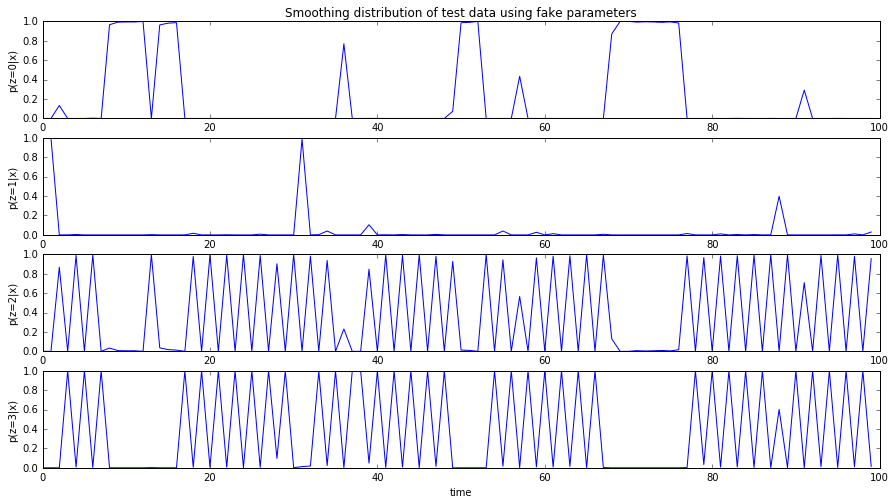

In [4]:
K = 4
testdata = np.loadtxt('EMGaussian.test') 
#Custom initialization
A = np.ones(16).reshape(K, K)*1/6.0
np.fill_diagonal(A, 0.5)
pis = np.ones(K)*1/4.0

#Compute the emissions probabilities
emissions = np.zeros((K, testdata.shape[0]))
for i in range(K):
    emissions[i] = [multivariate_normal.pdf(x, full_gm_model.mus[i], full_gm_model.variance[i]) for x in testdata]

alphas = np.zeros((testdata.shape[0], K))
alphas_norm_cst = np.zeros(testdata.shape[0])
betas = np.zeros((testdata.shape[0], K))

#Compute alphas and betas
alpha(testdata.shape[0] - 1, pis, emissions, A, alphas, alphas_norm_cst)
beta(0, emissions, A, betas, alphas_norm_cst)

#Compute the smoothing distribution
smoothing_dist = np.multiply(alphas, betas)

#Compute the initial likelihood
print "Q2 log likelihood:", np.sum(np.log(alphas_norm_cst))

plt.figure(figsize=(15,8))
xx = np.linspace(0, 99, 100)
plt.subplot(411)
plt.title('Smoothing distribution of test data using fake parameters')
plt.ylabel('p(z=0|x)')
plt.plot(xx, smoothing_dist[0:100, 0])
plt.subplot(412)
plt.ylabel('p(z=1|x)')
plt.plot(xx, smoothing_dist[0:100, 1])
plt.subplot(413)
plt.ylabel('p(z=2|x)')
plt.plot(xx, smoothing_dist[0:100, 2])
plt.subplot(414)
plt.ylabel('p(z=3|x)')
plt.plot(xx, smoothing_dist[0:100, 3])
plt.xlabel('time')
plt.show()

In [5]:
#Implementation details:
#The transition matrix is of the form A[i,j] where i represents the present state and j represents the past state
#Accordingly, the pair marginals are of the form s[i,j] where i and j represent the same as above
class hmm_model:
    def __init__(self, K, init_pis, A, init_means, init_covs):
        self.K = K
        self.pis = init_pis
        self.covs = init_covs
        self.mus = init_means
        self.transition_matrix = A
        
    def train(self, traindata, testdata):
        alphas = np.zeros((traindata.shape[0], self.K))
        alphas_norm_cst = np.zeros(traindata.shape[0])
        betas = np.zeros((traindata.shape[0], self.K))
        emissions = np.zeros((self.K, traindata.shape[0]))
        
        ##
        alphas_test = np.zeros((testdata.shape[0], self.K))
        alphas_norm_cst_test = np.zeros(testdata.shape[0])
        betas_test = np.zeros((testdata.shape[0], self.K))
        emissions_test = np.zeros((self.K, testdata.shape[0]))        
        ##                    
        
        iteration = 0
        self.log_likelihoods = []
        self.test_log_likelihoods = []

        #Compute the emissions probabilities
        for i in range(self.K):
            emissions[i] = [multivariate_normal.pdf(x, self.mus[i], self.covs[i]) for x in traindata]     
            
        #Compute log likelihoods for testdata
        for i in range(self.K):
            emissions_test[i] = [multivariate_normal.pdf(x, self.mus[i], self.covs[i]) for x in testdata]                       
        
        while (iteration < 2 or abs(self.log_likelihoods[iteration-1] - self.log_likelihoods[iteration-2]) > (10**-10)):
            #Compute the emissions probabilities
#             for i in range(self.K):
#                 emissions[i] = [multivariate_normal.pdf(x, self.mus[i], self.covs[i]) for x in traindata]   

            #Compute alphas and betas
            alpha(traindata.shape[0] - 1, self.pis, emissions, self.transition_matrix, alphas, alphas_norm_cst)
            beta(0, emissions, self.transition_matrix, betas, alphas_norm_cst)
                        
            self.log_likelihoods.append(np.sum(np.log(alphas_norm_cst)))
            
            #print "Log likelihood at iter {}: {}".format(iteration, log_likelihoods[iteration])
            #Compute log likelihoods for testdata
#             for i in range(self.K):
#                 emissions_test[i] = [multivariate_normal.pdf(x, self.mus[i], self.covs[i]) for x in testdata] 

            #Compute alphas FOR TESTDATA
            alpha(testdata.shape[0] - 1, self.pis, emissions_test, self.transition_matrix, alphas_test, alphas_norm_cst_test)            
            
            self.test_log_likelihoods.append(np.sum(np.log(alphas_norm_cst_test)))
                                                            
            
            ############################# E STEP ###############################
            #Compute the smoothing distribution
            smoothing_dist = np.multiply(alphas, betas)

            #Compute the pair marginals
            pair_marginals = np.zeros((traindata.shape[0]-1, self.K, self.K))

            for i in range(pair_marginals.shape[0]):
                pair_marginals[i] = self.transition_matrix.T*np.array([alphas[i],]).T.dot(np.array([betas[i+1]*emissions[:,i+1]],))/alphas_norm_cst[i+1]

            #print np.sum(pair_marginals)                
                
            ############################# M STEP ###############################
            for i in range(self.K):
                self.pis[i] = smoothing_dist[0, i]/np.sum(smoothing_dist[0])

            for i in range(K):
                for j in range(K):
                    #Remember that the transition matrix has to be in the same order as the pair marginals
                    #in terms of present and past states -- the denominator has to sum over all possible future states
                    self.transition_matrix[i, j] = np.sum(pair_marginals[:, j, i])/np.sum(pair_marginals[:, j, :])
            
            #print np.sum(self.transition_matrix, axis=0)
            
            #Means
            for i in range(K):
                self.mus[i] = smoothing_dist[:, i].T.dot(traindata)/np.sum(smoothing_dist[:, i])

            #Covariances
            for i in range(K):
                self.covs[i] = np.zeros((traindata.shape[1], traindata.shape[1]))

                for (j, x) in enumerate(traindata): 
                    diff = np.array([x - self.mus[i],])
                    self.covs[i]+= smoothing_dist[j,i]*diff.T.dot(diff)
                #After summing, divide
                self.covs[i] = self.covs[i]/np.sum(smoothing_dist[:, i])
                
            iteration+=1
            
        self.smoothing_dist = np.multiply(alphas, betas)

        
A = np.ones(16).reshape(K, K)*1/6.0
# A[0,2] = 0
# A[0,3] = 0
# A[2,3] = 0
# A[3,2] = 0
np.fill_diagonal(A, 0.5)
pis = np.ones(K)*1/4.0

model = hmm_model(4, pis, A, full_gm_model.mus, full_gm_model.variance)
model.train(np.loadtxt('EMGaussian.train'), np.loadtxt('EMGaussian.test'))

### Run HMM

Log likelihood on train data:  -1899.38413065
Log likelihood on test data:  -1958.21020419
Normalized log likelihood on train data:  -3.7987682613
Normalized log likelihood on test data:  -3.91642040837


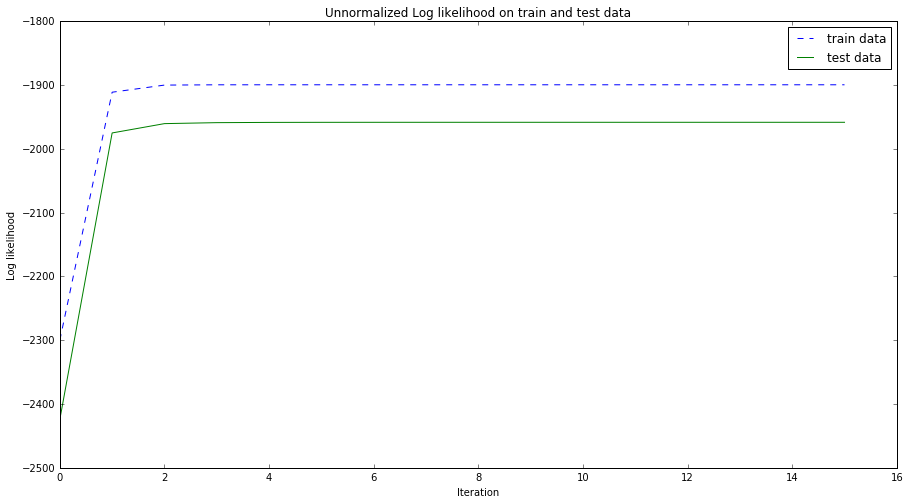

In [6]:
print "Log likelihood on train data: ", model.log_likelihoods[len(model.log_likelihoods)-1]
print "Log likelihood on test data: ", model.test_log_likelihoods[len(model.test_log_likelihoods)-1]
print "Normalized log likelihood on train data: ", \
    model.log_likelihoods[len(model.log_likelihoods)-1]/traindata.shape[0]
print "Normalized log likelihood on test data: ", \
    model.test_log_likelihoods[len(model.test_log_likelihoods)-1]/testdata.shape[0]

plt.figure(figsize=(15,8))
plt.title('Unnormalized Log likelihood on train and test data')
xx = [x for x in range(len(model.log_likelihoods))]
train_log_like, = plt.plot(xx, model.log_likelihoods, label='train data', linestyle='dashed')
test_log_like, = plt.plot(xx, model.test_log_likelihoods, label='test data')
plt.legend(handles=[train_log_like, test_log_like], loc=1)  
plt.ylabel('Log likelihood')
plt.xlabel('Iteration')
plt.show()

### Viterbi algorithm

In [7]:
#Inputs: data, K (number of states), transition matrix, emission probabilities, initial probabilities
#Outputs: log likelihood of most probable sequence of state, most probable sequence of states
def viterbi_decoding(data, K, transition_matrix, emissions, initial_probs):
    max_p_states = np.zeros((data.shape[0], K))
    most_likely_prev_state = np.zeros((data.shape[0], K))

    max_p_states[0] = [ np.log(initial_probs[i])+np.log(emissions[i,0]) for i in range(K)]
    most_likely_prev_state[0] = np.argmax(max_p_states[0])

    for t in range(1, data.shape[0]):
        for j in range(K):
            max_p_states[t,j] = np.max([max_p_states[t-1, i]+np.log(transition_matrix[j, i])+np.log(emissions[j, t]) for i in range(K) ])        
            most_likely_prev_state[t,j] = np.argmax([max_p_states[t-1, i]+np.log(transition_matrix[j, i])+np.log(emissions[j, t]) for i in range(K) ])

    #print "Log likelihood of most probable path:", np.max(max_p_states[data.shape[0] - 1])

    last_state = np.argmax(max_p_states[data.shape[0] - 1])
    sequence_states = np.zeros(data.shape[0], dtype=np.int)
    sequence_states[data.shape[0] - 1] = last_state

    for t in range(data.shape[0] - 2,-1,-1):
        sequence_states[t] = most_likely_prev_state[t+1, sequence_states[t+1]]

    return np.max(max_p_states[data.shape[0] - 1]), sequence_states

Log likelihood of most probable path: -1899.56214928


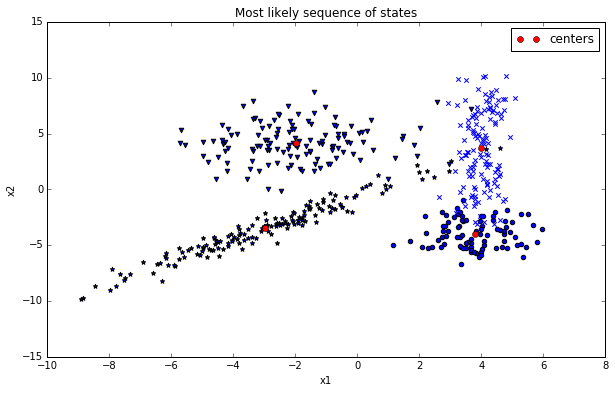

In [8]:
emissions = np.zeros((model.K, traindata.shape[0]))
        
for i in range(model.K):
    emissions[i] = [multivariate_normal.pdf(x, model.mus[i], model.covs[i]) for x in traindata]

log_likelihood, sequence_states = viterbi_decoding(np.loadtxt('EMGaussian.train'), 
                                                   model.K, model.transition_matrix, emissions, model.pis)

assert (traindata[sequence_states[:] == 0,:].shape[0] \
        + traindata[sequence_states[:] == 1,:].shape[0] \
        + traindata[sequence_states[:] == 2,:].shape[0] \
        + traindata[sequence_states[:] == 3,:].shape[0]) == 500
    
print "Log likelihood of most probable path:", log_likelihood

plt.figure(figsize=(10,6))
plt.title('Most likely sequence of states')
pts_center, = plt.plot(model.mus[:, 0], model.mus[:, 1], 'ro', label='centers')
plt.legend(handles=[pts_center], loc=1)  
plt.scatter(traindata[sequence_states[:] == 0, 0], traindata[sequence_states[:] == 0, 1], marker='o')
plt.scatter(traindata[sequence_states[:] == 1, 0], traindata[sequence_states[:] == 1, 1], marker='*')
plt.scatter(traindata[sequence_states[:] == 2, 0], traindata[sequence_states[:] == 2, 1], marker='x')
plt.scatter(traindata[sequence_states[:] == 3, 0], traindata[sequence_states[:] == 3, 1], marker='v')  
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Marginal probability latent variables in test data using learned parameters

Log likelihood: -1956.7700187


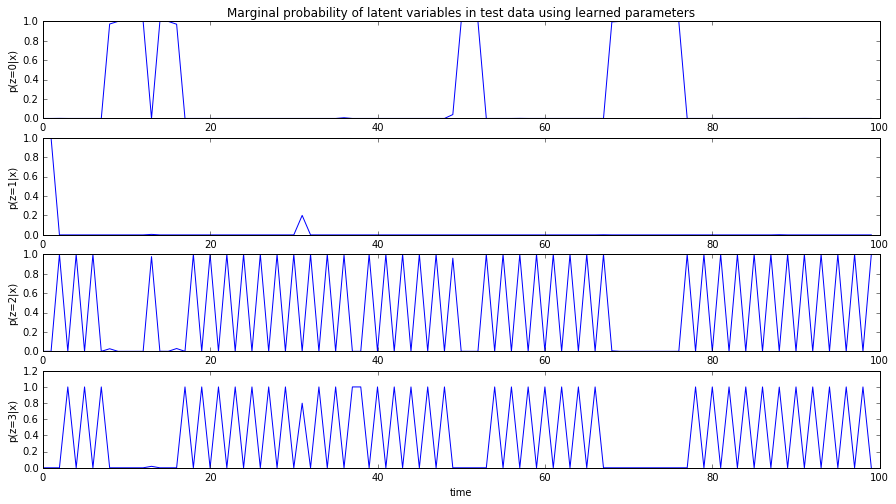

In [9]:
#Need to do an alpha-beta recursion with learned parameters
alphas_t = np.zeros((testdata.shape[0], model.K))
alphas_norm_cst_t = np.zeros(testdata.shape[0])
betas_t = np.zeros((testdata.shape[0], model.K))
emissions_t = np.zeros((model.K, testdata.shape[0]))  

#Compute emissions
for i in range(model.K):
    emissions_t[i] = [multivariate_normal.pdf(x, model.mus[i], model.covs[i]) for x in testdata] 

#Compute alphas and betas
alpha(testdata.shape[0] - 1, model.pis, emissions_t, model.transition_matrix, alphas_t, alphas_norm_cst_t)
beta(0, emissions_t, model.transition_matrix, betas_t, alphas_norm_cst_t)

print "Log likelihood:", np.sum(np.log(alphas_norm_cst_t))

#Compute the smoothing distribution
smoothing_dist_t = np.multiply(alphas_t, betas_t)

plt.figure(figsize=(15,8))
xx = np.linspace(0, 99, 100)
plt.subplot(411)
plt.title('Marginal probability of latent variables in test data using learned parameters')
plt.ylabel('p(z=0|x)')
plt.plot(xx, smoothing_dist_t[0:100, 0])
plt.subplot(412)
plt.ylabel('p(z=1|x)')
plt.plot(xx, smoothing_dist_t[0:100, 1])
plt.subplot(413)
plt.ylabel('p(z=2|x)')
plt.plot(xx, smoothing_dist_t[0:100, 2])
plt.subplot(414)
plt.ylabel('p(z=3|x)')
plt.plot(xx, smoothing_dist_t[0:100, 3])
plt.xlabel('time')
plt.show()

### Most likely state of each point test data

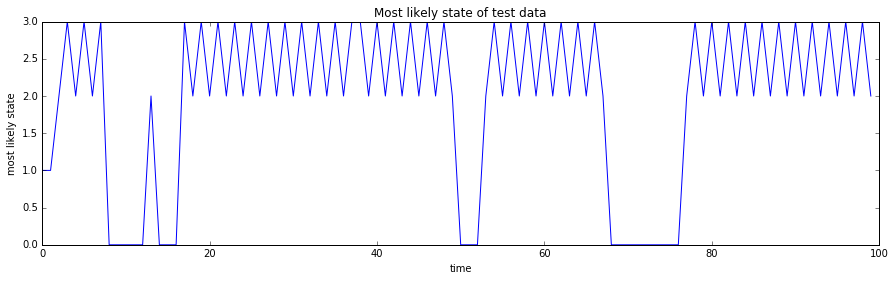

[[ 0.87845544  0.02041065  0.01040267  0.04861213]
 [ 0.03400797  0.89997114  0.03342726  0.06317083]
 [ 0.04306557  0.07295061  0.02654057  0.87248674]
 [ 0.04447102  0.0066676   0.9296295   0.0157303 ]]


In [10]:
most_likely_states = np.argmax(smoothing_dist_t[0:100], axis=1)

plt.figure(figsize=(15,4))
xx = np.linspace(0, 99, 100)
plt.plot(xx, most_likely_states)
plt.title('Most likely state of test data')
plt.ylabel('most likely state')
plt.xlabel('time')
plt.show()

print model.transition_matrix

### Viterbi on test data

Log likelihood of most probable path on test data: -1958.76942942


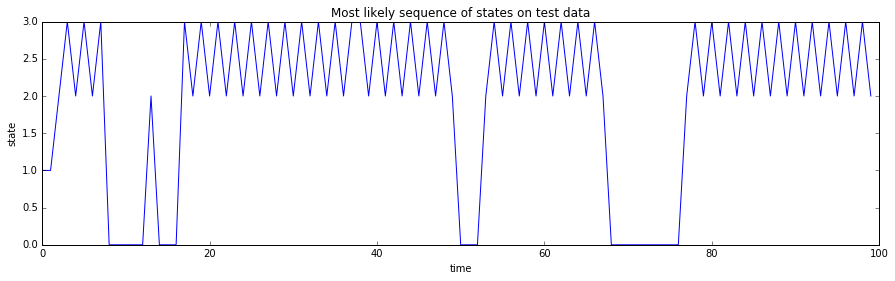

In [11]:
emissions_t = np.zeros((model.K, testdata.shape[0]))
        
for i in range(model.K):
    emissions_t[i] = [multivariate_normal.pdf(x, model.mus[i], model.covs[i]) for x in testdata]

log_likelihood, sequence_states = viterbi_decoding(np.loadtxt('EMGaussian.test'), 
                                                   model.K, model.transition_matrix, emissions_t, model.pis)

assert (testdata[sequence_states[:] == 0,:].shape[0] \
        + testdata[sequence_states[:] == 1,:].shape[0] \
        + testdata[sequence_states[:] == 2,:].shape[0] \
        + testdata[sequence_states[:] == 3,:].shape[0]) == 500
    
print "Log likelihood of most probable path on test data:", log_likelihood

plt.figure(figsize=(15,4))
xx = np.linspace(0, 99, 100)
plt.plot(xx, sequence_states[0:100])
plt.title('Most likely sequence of states on test data')
plt.ylabel('state')
plt.xlabel('time')
plt.show()
